# 1. 导入库

In [1]:
import time
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') # 展示高清图，在 Jupyter Notebook 中设置 matplotlib 图形的输出格式为 SVG 格式

import torch
import torch.nn as nn
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as TTS
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

import random
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

E:\Anaconda\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. 读取数据+预处理+PCA降维+划分数据集

#### （1）读取数据+预处理+PCA降维

In [2]:
# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv(r"F:\Code_Data\2_Rocks_Spectrum_Reflectance_essay_30_origin_modify_2.csv",encoding='utf-8') #encoding='GBK',防止中文乱码

In [4]:
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]
X_SG = savgol_filter(X, 5, 2)
X_SG_mms = MinMaxScaler().fit_transform(X_SG)
Label = LabelEncoder().fit_transform(y)
data.iloc[:,1:-1] = X_SG_mms
data.iloc[:, -1] = Label
X = data.iloc[:,1:-1]
y = data.iloc[:,-1]

In [5]:
X.shape, y.shape

((11828, 2151), (11828,))

In [6]:
X_dr = PCA(29).fit_transform(X)

In [7]:
# 转换为 torch 中的张量格式
X_tensor = torch.tensor(X_dr, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

In [8]:
# 将数据移动到GPU
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

In [9]:
X_tensor.shape, y_tensor.shape

(torch.Size([11828, 29]), torch.Size([11828]))

#### （2）使用和RF和Xgvoost相同的划分数据集的方法

In [11]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X_dr,y,test_size=0.3,random_state=0)

In [12]:
# 转换为 torch 中的张量格式
X_train_tensor = torch.tensor(Xtrain, dtype=torch.float32)
X_test_tensor = torch.tensor(Xtest, dtype=torch.float32)
y_train_tensor = torch.tensor(Ytrain, dtype=torch.long)
y_test_array = Ytest.values
y_test_tensor = torch.tensor(y_test_array, dtype=torch.long)

In [13]:
# 将数据移动到GPU
X_train_tensor = X_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [14]:
# 创建训练集和测试集的 TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# 创建 DataLoader 对象
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

train_size = len(train_dataset)
test_size = len(test_dataset)

In [15]:
train_size, test_size

(8279, 3549)

#### （3）常规划分训练集和测试集

In [115]:
# 创建 TensorDataset 对象
Data = TensorDataset(X_tensor,y_tensor)

In [ ]:
# 创建 DataLoader 对象，用于批量加载数据
dataloader = DataLoader(Data, batch_size=128,shuffle=True)

In [66]:
# 划分训练集和测试集
train_ratio = 0.7
dataset_size = len(Data)
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

# 使用 random_split 方法将数据集分成训练集和测试集
train_dataset, test_dataset = random_split(Data, [train_size, test_size])

# 创建训练集 DataLoader 对象
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True) # shuffle 用于在每一个 epoch 内先洗牌再分批。

# 创建测试集 DataLoader 对象
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [67]:
train_size, test_size

(8083, 3465)

# 3. 搭建神经网络

#### （1）调整隐藏层尺寸，dropout概率

In [16]:
# 搭建网络
class DNN(nn.Module):
    def __init__(self, input_size, num_classes, hidden_layer_sizes, dropout_prob):
        ''' 搭建神经网络各层 '''
        super(DNN, self).__init__()

        self.hidden_layer_sizes = hidden_layer_sizes  # 调整隐藏层尺寸
        self.dropout_prob = dropout_prob  # 调整 dropout 概率

        layers = []
        prev_layer_size = input_size

        for layer_size in self.hidden_layer_sizes:
            layers.append(nn.Linear(prev_layer_size, layer_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(self.dropout_prob))
            prev_layer_size = layer_size

        layers.append(nn.Linear(prev_layer_size, num_classes))

        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [17]:
# 超参数
num_classes = 33
input_size = X_tensor.shape[1]
hidden_layer_sizes = [32, 64, 128]  # 你可以根据需要调整隐藏层尺寸
dropout_prob = 0.3  # 你可以根据需要调整 dropout 概率

In [18]:
# 创建模型实例
model = DNN(input_size, num_classes, hidden_layer_sizes, dropout_prob)
model.to(device)
print(model)

DNN(
  (net): Sequential(
    (0): Linear(in_features=29, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=33, bias=True)
  )
)


#### （2）简单的搭建

In [55]:
class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        ''' 搭建神经网络各层 '''
        super(DNN,self).__init__()
        self.net = nn.Sequential(nn.Linear(30, 32), nn.ReLU() # 第 1 层：全连接层
                                 ,nn.Linear(32, 8), nn.ReLU() # 第 2 层：全连接层
                                 ,nn.Linear(8, 4), nn.ReLU() # 第 3 层：全连接层
                                 ,nn.Linear(4, num_classes)# 第 4 层：全连接层，输出节点数设置为类别的数量
                                )
    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x) # x 即输入数据
        return y # y 即输出数据

In [56]:
num_classes = len(np.unique(y))  # 类别的数量
input_size = X_tensor.shape[1]  # 输入特征的维度，即特征数量
model = DNN(input_size, num_classes)
#model = DNN().to('cuda:0') # 创建子类的实例，并搬到 GPU 上
model # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=33, bias=True)
  )
)

# 4. 训练网络

In [254]:
# 损失函数的选择
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量

In [255]:
# 优化算法的选择
learning_rate = 0.001 # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [256]:
# 训练网络
epochs = 200
accuracies = [] # 记录准确率变化的列表
losses = [] # 记录损失函数变化的列表
for epoch in range(epochs):
    total_correct = 0
    total_samples = 0
    
    for (x, y) in train_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)
        total_correct += torch.sum(Pred_classes == y)
        total_samples += y.size(0)
        loss = loss_fn(Pred, y) # 计算损失函数
        losses.append(loss.item()) # 记录损失函数的变化
        optimizer.zero_grad() # 清理上一轮滞留的梯度
        loss.backward() # 一次反向传播
        optimizer.step() # 优化内部参数
        
    accuracy = total_correct / total_samples
    accuracies.append(accuracy.item())

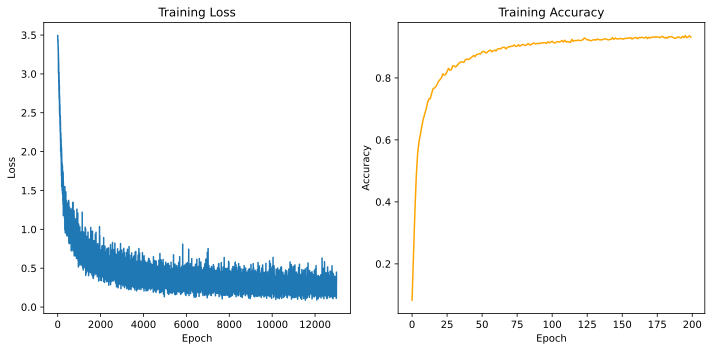

In [257]:
# 绘制损失曲线和准确率变化曲线
plt.figure(figsize=(10, 5))  # 设置整体图的大小

# 创建第一个子图（左侧），绘制训练损失曲线
plt.subplot(1, 2, 1)  # 参数依次为：行数，列数，子图编号
plt.plot(range(len(losses)), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# 创建第二个子图（右侧），绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies)), accuracies, color='orange')  # 使用橙色表示准确率
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout() # 调整子图的布局，防止重叠

# 5. 测试网络

In [258]:
# 测试网络
correct = 0
total = 0
all_preds = []
all_labels = []
with torch.no_grad(): # 该局部关闭梯度计算功能
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)
        Pred = model(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total += y.size(0)
print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 93.15299987792969 %


In [20]:
# 混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 6. Optuna——随机网格搜索，调参

#### （1）构建目标函数及定义参数空间¶

In [22]:
def optuna_objective(trial):
    
    # 定义超参数空间
    #hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(len(hidden_layer_sizes))]
    hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(trial.suggest_int("num_hidden_layers", 3, 5))]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5)
    
    # 根据超参数定义 DNN 模型
    model = DNN(input_size, num_classes, hidden_layer_sizes, dropout_prob)
    model.to(device)
    
    # 定义优化器和损失函数
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCHS = 200
    
    # 训练模型
    model.train()
    for epoch in range(EPOCHS):
        for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model(x) # 一次前向传播（小批量）
            loss = loss_fn(output, y) # 计算损失函数
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
    
    # 验证模型
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for (x, y) in test_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            Pred = model(x) # 一次前向传播（小批量）
            _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
            correct += torch.sum(Pred_classes == y)  # 计算正确的个数
            all_preds.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
            all_labels.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
            total += y.size(0)
    accuracy = correct/total
    
    # 报告准确率给 Optuna
    trial.report(accuracy, epoch)
    
    return accuracy

#### （2）定义优化目标函数的具体流程

In [23]:
# 定义超参数优化器函数
def optimizer_optuna(n_trials, algo):

    #定义使用随机网格搜索
    sampler = optuna.samplers.RandomSampler(seed=0)

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = sampler #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #要不要展示进度条呀？
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [24]:
def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 进行随机网格搜索优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    print("\n","\n","best params: ", best_params,
          "\n","\n","best score: ", best_score,
          "\n")

    end_time = time.time()
    time_random = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_random} minutes.")

    return best_params, best_score, time_random

# 执行优化
best_params, best_score, time_random = optimized_optuna_search_and_report(30, "Random")

[I 2023-08-30 12:39:36,695] A new study created in memory with name: no-name-a9af5b84-ed98-4694-a66f-3a08a7802b95
Best trial: 0. Best value: 0.599324:   3%|█▌                                            | 1/30 [01:12<35:16, 72.97s/it]

[I 2023-08-30 12:40:49,664] Trial 0 finished with value: 0.5993237495422363 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 188, 'hidden_layer_size_1': 161, 'hidden_layer_size_2': 147, 'hidden_layer_size_3': 118, 'learning_rate': 0.0038333321561566623, 'dropout_prob': 0.275034884505077, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.5993237495422363.


Best trial: 0. Best value: 0.599324:   7%|███                                           | 2/30 [02:09<29:28, 63.17s/it]

[I 2023-08-30 12:41:45,971] Trial 1 finished with value: 0.17892365157604218 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 143, 'hidden_layer_size_1': 152, 'hidden_layer_size_2': 239, 'hidden_layer_size_3': 33, 'hidden_layer_size_4': 36, 'learning_rate': 1.2046852412030316e-05, 'dropout_prob': 0.4330479382191752, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5993237495422363.


Best trial: 0. Best value: 0.599324:  10%|████▌                                         | 3/30 [03:02<26:19, 58.48s/it]

[I 2023-08-30 12:42:38,877] Trial 2 finished with value: 0.034939419478178024 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 127, 'hidden_layer_size_1': 204, 'hidden_layer_size_2': 44, 'hidden_layer_size_3': 170, 'hidden_layer_size_4': 50, 'learning_rate': 0.06007249475906202, 'dropout_prob': 0.3087393287000287, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.5993237495422363.


Best trial: 3. Best value: 0.915187:  13%|██████▏                                       | 4/30 [03:58<24:54, 57.50s/it]

[I 2023-08-30 12:43:34,867] Trial 3 finished with value: 0.915187418460846 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 152, 'hidden_layer_size_1': 20, 'hidden_layer_size_2': 164, 'hidden_layer_size_3': 163, 'learning_rate': 0.002935864364395358, 'dropout_prob': 0.4774992314058497, 'optimizer': 'Adam'}. Best is trial 3 with value: 0.915187418460846.


Best trial: 3. Best value: 0.915187:  17%|███████▋                                      | 5/30 [04:51<23:17, 55.91s/it]

[I 2023-08-30 12:44:27,956] Trial 4 finished with value: 0.91377854347229 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 30, 'hidden_layer_size_1': 176, 'hidden_layer_size_2': 177, 'hidden_layer_size_3': 66, 'hidden_layer_size_4': 47, 'learning_rate': 0.0001826894228153232, 'dropout_prob': 0.24548430837704904, 'optimizer': 'RMSprop'}. Best is trial 3 with value: 0.915187418460846.


Best trial: 5. Best value: 0.946746:  20%|█████████▏                                    | 6/30 [05:41<21:31, 53.83s/it]

[I 2023-08-30 12:45:17,752] Trial 5 finished with value: 0.9467455744743347 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 66, 'hidden_layer_size_1': 54, 'hidden_layer_size_2': 173, 'learning_rate': 0.00010307810128023635, 'dropout_prob': 0.2865243091425225, 'optimizer': 'Adam'}. Best is trial 5 with value: 0.9467455744743347.


Best trial: 5. Best value: 0.946746:  23%|██████████▋                                   | 7/30 [06:20<18:50, 49.15s/it]

[I 2023-08-30 12:45:57,155] Trial 6 finished with value: 0.054381515830755234 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 49, 'hidden_layer_size_1': 63, 'hidden_layer_size_2': 104, 'hidden_layer_size_3': 213, 'learning_rate': 2.445710810231886e-05, 'dropout_prob': 0.4351779629995216, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.9467455744743347.


Best trial: 5. Best value: 0.946746:  27%|████████████▎                                 | 8/30 [07:03<17:14, 47.04s/it]

[I 2023-08-30 12:46:39,770] Trial 7 finished with value: 0.02451394870877266 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 161, 'hidden_layer_size_1': 194, 'hidden_layer_size_2': 25, 'hidden_layer_size_3': 84, 'hidden_layer_size_4': 44, 'learning_rate': 0.0001529539827781372, 'dropout_prob': 0.14749108758169763, 'optimizer': 'SGD'}. Best is trial 5 with value: 0.9467455744743347.


Best trial: 5. Best value: 0.946746:  30%|█████████████▊                                | 9/30 [07:54<16:58, 48.50s/it]

[I 2023-08-30 12:47:31,501] Trial 8 finished with value: 0.06142575666308403 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 152, 'hidden_layer_size_1': 79, 'hidden_layer_size_2': 142, 'hidden_layer_size_3': 38, 'hidden_layer_size_4': 154, 'learning_rate': 0.05214165242447226, 'dropout_prob': 0.22742758098052948, 'optimizer': 'RMSprop'}. Best is trial 5 with value: 0.9467455744743347.


Best trial: 9. Best value: 0.964497:  33%|███████████████                              | 10/30 [08:36<15:27, 46.37s/it]

[I 2023-08-30 12:48:13,080] Trial 9 finished with value: 0.9644970893859863 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 60, 'hidden_layer_size_1': 157, 'hidden_layer_size_2': 20, 'learning_rate': 0.02068998219217129, 'dropout_prob': 0.10187819047701883, 'optimizer': 'RMSprop'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  37%|████████████████▌                            | 11/30 [09:41<16:28, 52.00s/it]

[I 2023-08-30 12:49:17,869] Trial 10 finished with value: 0.03324880450963974 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 75, 'hidden_layer_size_1': 154, 'hidden_layer_size_2': 158, 'hidden_layer_size_3': 153, 'hidden_layer_size_4': 69, 'learning_rate': 0.06471367240175245, 'dropout_prob': 0.27885015144705094, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  40%|██████████████████                           | 12/30 [10:44<16:36, 55.37s/it]

[I 2023-08-30 12:50:20,939] Trial 11 finished with value: 0.9625246524810791 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 111, 'hidden_layer_size_1': 228, 'hidden_layer_size_2': 156, 'hidden_layer_size_3': 228, 'hidden_layer_size_4': 182, 'learning_rate': 0.007961907345193564, 'dropout_prob': 0.30052975277068095, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  43%|███████████████████▌                         | 13/30 [11:30<14:55, 52.65s/it]

[I 2023-08-30 12:51:07,331] Trial 12 finished with value: 0.944491446018219 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 20, 'hidden_layer_size_1': 88, 'hidden_layer_size_2': 175, 'hidden_layer_size_3': 85, 'learning_rate': 0.0029652527407725646, 'dropout_prob': 0.27150748037830646, 'optimizer': 'RMSprop'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  47%|█████████████████████                        | 14/30 [12:09<12:55, 48.45s/it]

[I 2023-08-30 12:51:46,084] Trial 13 finished with value: 0.9470273852348328 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 154, 'hidden_layer_size_1': 173, 'hidden_layer_size_2': 173, 'hidden_layer_size_3': 119, 'learning_rate': 0.03856438264681121, 'dropout_prob': 0.24702474801915864, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  50%|██████████████████████▌                      | 15/30 [13:01<12:22, 49.49s/it]

[I 2023-08-30 12:52:37,975] Trial 14 finished with value: 0.11017188429832458 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 40, 'hidden_layer_size_1': 237, 'hidden_layer_size_2': 188, 'hidden_layer_size_3': 256, 'hidden_layer_size_4': 52, 'learning_rate': 0.029682756505313473, 'dropout_prob': 0.16499717387054993, 'optimizer': 'RMSprop'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  53%|████████████████████████                     | 16/30 [14:04<12:31, 53.66s/it]

[I 2023-08-30 12:53:41,333] Trial 15 finished with value: 0.728374183177948 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 153, 'hidden_layer_size_1': 114, 'hidden_layer_size_2': 32, 'hidden_layer_size_3': 184, 'hidden_layer_size_4': 125, 'learning_rate': 0.007730763684620935, 'dropout_prob': 0.4465529303714517, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  57%|█████████████████████████▌                   | 17/30 [15:01<11:51, 54.70s/it]

[I 2023-08-30 12:54:38,454] Trial 16 finished with value: 0.9312482476234436 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 191, 'hidden_layer_size_1': 57, 'hidden_layer_size_2': 141, 'hidden_layer_size_3': 29, 'learning_rate': 6.30937149822963e-05, 'dropout_prob': 0.1074087177842456, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  60%|███████████████████████████                  | 18/30 [16:05<11:28, 57.40s/it]

[I 2023-08-30 12:55:42,126] Trial 17 finished with value: 0.7492251396179199 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 185, 'hidden_layer_size_1': 23, 'hidden_layer_size_2': 55, 'hidden_layer_size_3': 165, 'hidden_layer_size_4': 155, 'learning_rate': 8.94481340878346e-05, 'dropout_prob': 0.4736855991699175, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  63%|████████████████████████████▌                | 19/30 [16:48<09:45, 53.19s/it]

[I 2023-08-30 12:56:25,513] Trial 18 finished with value: 0.6813187003135681 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 91, 'hidden_layer_size_1': 111, 'hidden_layer_size_2': 66, 'hidden_layer_size_3': 60, 'hidden_layer_size_4': 243, 'learning_rate': 0.009082453440211006, 'dropout_prob': 0.2961835234470268, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  67%|██████████████████████████████               | 20/30 [17:44<08:59, 53.95s/it]

[I 2023-08-30 12:57:21,234] Trial 19 finished with value: 0.7557058334350586 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 91, 'hidden_layer_size_1': 183, 'hidden_layer_size_2': 107, 'hidden_layer_size_3': 59, 'learning_rate': 1.2552057312500426e-05, 'dropout_prob': 0.12689985258529946, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  70%|███████████████████████████████▍             | 21/30 [18:36<07:59, 53.32s/it]

[I 2023-08-30 12:58:13,084] Trial 20 finished with value: 0.8977177143096924 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 254, 'hidden_layer_size_1': 68, 'hidden_layer_size_2': 175, 'hidden_layer_size_3': 79, 'hidden_layer_size_4': 20, 'learning_rate': 0.010802259731953855, 'dropout_prob': 0.22800686032898715, 'optimizer': 'RMSprop'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  73%|█████████████████████████████████            | 22/30 [19:15<06:32, 49.12s/it]

[I 2023-08-30 12:58:52,406] Trial 21 finished with value: 0.9436461329460144 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 226, 'hidden_layer_size_1': 81, 'hidden_layer_size_2': 208, 'hidden_layer_size_3': 60, 'learning_rate': 0.06473909557586699, 'dropout_prob': 0.37499531055512614, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  77%|██████████████████████████████████▌          | 23/30 [19:50<05:14, 44.96s/it]

[I 2023-08-30 12:59:27,667] Trial 22 finished with value: 0.06677937507629395 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 67, 'hidden_layer_size_1': 140, 'hidden_layer_size_2': 22, 'learning_rate': 6.758966622072009e-05, 'dropout_prob': 0.26987418750060255, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  80%|████████████████████████████████████         | 24/30 [20:47<04:51, 48.57s/it]

[I 2023-08-30 13:00:24,659] Trial 23 finished with value: 0.9642152786254883 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 224, 'hidden_layer_size_1': 44, 'hidden_layer_size_2': 140, 'hidden_layer_size_3': 47, 'learning_rate': 0.007369511905048896, 'dropout_prob': 0.2584238811229175, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  83%|█████████████████████████████████████▌       | 25/30 [21:34<03:59, 47.95s/it]

[I 2023-08-30 13:01:11,162] Trial 24 finished with value: 0.06649760901927948 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 101, 'hidden_layer_size_1': 242, 'hidden_layer_size_2': 200, 'hidden_layer_size_3': 196, 'learning_rate': 0.041198268053920954, 'dropout_prob': 0.13336897417680743, 'optimizer': 'RMSprop'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  87%|███████████████████████████████████████      | 26/30 [22:24<03:14, 48.57s/it]

[I 2023-08-30 13:02:01,195] Trial 25 finished with value: 0.13299521803855896 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 74, 'hidden_layer_size_1': 40, 'hidden_layer_size_2': 19, 'learning_rate': 0.05225372642279875, 'dropout_prob': 0.36796661863636404, 'optimizer': 'Adam'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  90%|████████████████████████████████████████▌    | 27/30 [23:00<02:14, 44.82s/it]

[I 2023-08-30 13:02:37,268] Trial 26 finished with value: 0.10171879827976227 and parameters: {'num_hidden_layers': 3, 'hidden_layer_size_0': 133, 'hidden_layer_size_1': 251, 'hidden_layer_size_2': 227, 'learning_rate': 0.0002252349634321645, 'dropout_prob': 0.48462806181659945, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  93%|██████████████████████████████████████████   | 28/30 [23:43<01:28, 44.35s/it]

[I 2023-08-30 13:03:20,526] Trial 27 finished with value: 0.034939419478178024 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 167, 'hidden_layer_size_1': 226, 'hidden_layer_size_2': 86, 'hidden_layer_size_3': 220, 'hidden_layer_size_4': 164, 'learning_rate': 1.1296591673520513e-05, 'dropout_prob': 0.23889340717288784, 'optimizer': 'SGD'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 9. Best value: 0.964497:  97%|███████████████████████████████████████████▌ | 29/30 [24:30<00:45, 45.16s/it]

[I 2023-08-30 13:04:07,581] Trial 28 finished with value: 0.9056072235107422 and parameters: {'num_hidden_layers': 4, 'hidden_layer_size_0': 170, 'hidden_layer_size_1': 104, 'hidden_layer_size_2': 48, 'hidden_layer_size_3': 214, 'learning_rate': 5.7463443507233836e-05, 'dropout_prob': 0.30452759301858245, 'optimizer': 'RMSprop'}. Best is trial 9 with value: 0.9644970893859863.


Best trial: 29. Best value: 0.965061: 100%|████████████████████████████████████████████| 30/30 [25:22<00:00, 50.76s/it]

[I 2023-08-30 13:04:59,481] Trial 29 finished with value: 0.9650605916976929 and parameters: {'num_hidden_layers': 5, 'hidden_layer_size_0': 247, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 35, 'learning_rate': 0.0004255638073105697, 'dropout_prob': 0.19289365686837712, 'optimizer': 'RMSprop'}. Best is trial 29 with value: 0.9650605916976929.

 
 best params:  {'num_hidden_layers': 5, 'hidden_layer_size_0': 247, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 35, 'learning_rate': 0.0004255638073105697, 'dropout_prob': 0.19289365686837712, 'optimizer': 'RMSprop'} 
 
 best score:  [0.9650605916976929] 


 
 best params:  {'num_hidden_layers': 5, 'hidden_layer_size_0': 247, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 35, 'learning_rate': 0.0004255638073105697, 'dropout_prob': 0.19289365686837712, 'optimizer': 

# 7. Optuna——贝叶斯优化，调参

#### （1）构建目标函数及定义参数空间

In [19]:
def optuna_objective(trial):
    
    # 定义超参数空间
    # 层数固定
    hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(5)]
    # 层数3-5层
    # hidden_layer_sizes = [trial.suggest_int(f"hidden_layer_size_{i}", 16, 256) for i in range(trial.suggest_int("num_hidden_layers", 3, 5))]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_prob = trial.suggest_float("dropout_prob", 0.1, 0.5, step=0.01)
    
    
    # 根据超参数定义 DNN 模型
    model = DNN(input_size, num_classes, hidden_layer_sizes, dropout_prob)
    model.to(device)
    
    # 定义优化器和损失函数
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSprop"])
    if optimizer_name == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_name == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.CrossEntropyLoss()
    EPOCHS = 200
    
    # 训练模型
    model.train()
    for epoch in range(EPOCHS):
        for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model(x) # 一次前向传播（小批量）
            loss = loss_fn(output, y) # 计算损失函数
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
    
    # 验证模型
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for (x, y) in test_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            Pred = model(x) # 一次前向传播（小批量）
            _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
            correct += torch.sum(Pred_classes == y)  # 计算正确的个数
            all_preds.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
            all_labels.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
            total += y.size(0)
    accuracy = correct/total
    
    # 报告准确率给 Optuna
    trial.report(accuracy, epoch)
    
    return accuracy

#### （2）定义优化目标函数的具体流程

In [20]:
# 定义超参数优化器函数
def optimizer_optuna(n_trials, algo):

    #定义使用TPE或者GP
    if algo == "TPE":
        algo = optuna.samplers.TPESampler(n_startup_trials = 15, n_ei_candidates = 12)
    elif algo == "GP":
        from optuna.integration import SkoptSampler
        import skopt
        algo = SkoptSampler(skopt_kwargs={'base_estimator':'GP', #选择高斯过程
                                          'n_initial_points':30, #初始观测点10个
                                          'acq_func':'EI'} #选择的采集函数为EI，期望增量
                           )

    #实际优化过程，首先实例化优化器
    study = optuna.create_study(sampler = algo #要使用的具体算法
                                ,direction="maximize" #优化的方向，可以填写minimize或maximize
                               )
    #开始优化，n_trials为允许的最大迭代次数
    #由于参数空间已经在目标函数中定义好，因此不需要输入参数空间
    study.optimize(optuna_objective #目标函数
                   ,n_trials=n_trials #最大迭代次数（包括最初的观测值的）
                   ,show_progress_bar=True #展示进度条
                  )

    #可直接从优化好的对象study中调用优化的结果
    #打印最佳参数与最佳损失值
    print("\n","\n","best params: ", study.best_trial.params,
          "\n","\n","best score: ", study.best_trial.values,
          "\n")

    return study.best_trial.params, study.best_trial.values

#### （3）执行优化操作

In [21]:
import time

def optimized_optuna_search_and_report(n_trials, algo):
    start_time = time.time()

    # 定义使用TPE或者GP
    #if algo == "TPE":
    #    algo_sampler = optuna.samplers.TPESampler(n_startup_trials=50, n_ei_candidates=12)
    #elif algo == "GP":
    #    from optuna.integration import SkoptSampler
    #    import skopt
    #    algo_sampler = SkoptSampler(skopt_kwargs={'base_estimator': 'GP',
    #                                              'n_initial_points': 30,
    #                                              'acq_func': 'EI'})

    # 进行超参数优化
    #study = optuna.create_study(sampler=algo_sampler, direction="maximize")
    #study.optimize(optuna_objective, n_trials=n_trials, show_progress_bar=True)
    
    # 进行贝叶斯优化
    best_params, best_score = optimizer_optuna(n_trials, algo)

    # 打印最佳参数和分数
    #best_trial = study.best_trial
    #best_params = best_trial.params
    #best_score = best_trial.value
    print("\n", "\n", "best params: ", best_params,
          "\n", "\n", "best score: ", best_score,
          "\n")

    end_time = time.time()
    time_bayes = (end_time - start_time) / 60  # 转换为分钟
    print(f"Optimization completed in {time_bayes} minutes.")

    return best_params, best_score, time_bayes

# 执行优化
best_params, best_score, time_bayes = optimized_optuna_search_and_report(100, "TPE")

[I 2023-09-12 11:52:57,207] A new study created in memory with name: no-name-e33054e0-5fac-46cc-98f0-49de4d79f22d
Best trial: 0. Best value: 0.0307129:   1%|▍                                        | 1/100 [02:17<3:46:26, 137.24s/it]

[I 2023-09-12 11:55:14,613] Trial 0 finished with value: 0.030712878331542015 and parameters: {'hidden_layer_size_0': 124, 'hidden_layer_size_1': 249, 'hidden_layer_size_2': 208, 'hidden_layer_size_3': 55, 'hidden_layer_size_4': 118, 'learning_rate': 0.057661505890424285, 'dropout_prob': 0.38, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 0.030712878331542015.


Best trial: 1. Best value: 0.966751:   2%|▊                                         | 2/100 [04:10<3:20:43, 122.90s/it]

[I 2023-09-12 11:57:07,470] Trial 1 finished with value: 0.966751217842102 and parameters: {'hidden_layer_size_0': 139, 'hidden_layer_size_1': 89, 'hidden_layer_size_2': 162, 'hidden_layer_size_3': 49, 'hidden_layer_size_4': 222, 'learning_rate': 0.0004881279848759281, 'dropout_prob': 0.18, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   3%|█▎                                        | 3/100 [05:38<2:53:17, 107.19s/it]

[I 2023-09-12 11:58:35,978] Trial 2 finished with value: 0.09551987051963806 and parameters: {'hidden_layer_size_0': 167, 'hidden_layer_size_1': 227, 'hidden_layer_size_2': 168, 'hidden_layer_size_3': 126, 'hidden_layer_size_4': 160, 'learning_rate': 0.00017797016784781264, 'dropout_prob': 0.14, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   4%|█▋                                         | 4/100 [07:07<2:39:42, 99.82s/it]

[I 2023-09-12 12:00:04,496] Trial 3 finished with value: 0.9546351432800293 and parameters: {'hidden_layer_size_0': 181, 'hidden_layer_size_1': 121, 'hidden_layer_size_2': 213, 'hidden_layer_size_3': 183, 'hidden_layer_size_4': 125, 'learning_rate': 0.04621973688959496, 'dropout_prob': 0.13, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   5%|██                                        | 5/100 [09:26<3:00:33, 114.04s/it]

[I 2023-09-12 12:02:23,749] Trial 4 finished with value: 0.9295576214790344 and parameters: {'hidden_layer_size_0': 208, 'hidden_layer_size_1': 53, 'hidden_layer_size_2': 102, 'hidden_layer_size_3': 181, 'hidden_layer_size_4': 149, 'learning_rate': 5.1747109351042e-05, 'dropout_prob': 0.35, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   6%|██▌                                       | 6/100 [10:55<2:45:22, 105.56s/it]

[I 2023-09-12 12:03:52,834] Trial 5 finished with value: 0.4435052275657654 and parameters: {'hidden_layer_size_0': 235, 'hidden_layer_size_1': 80, 'hidden_layer_size_2': 128, 'hidden_layer_size_3': 188, 'hidden_layer_size_4': 184, 'learning_rate': 0.003136580568670095, 'dropout_prob': 0.47, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   7%|██▉                                       | 7/100 [12:24<2:35:01, 100.02s/it]

[I 2023-09-12 12:05:21,450] Trial 6 finished with value: 0.48267120122909546 and parameters: {'hidden_layer_size_0': 19, 'hidden_layer_size_1': 183, 'hidden_layer_size_2': 159, 'hidden_layer_size_3': 230, 'hidden_layer_size_4': 147, 'learning_rate': 0.004167172540687981, 'dropout_prob': 0.31, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   8%|███▎                                      | 8/100 [14:14<2:38:39, 103.48s/it]

[I 2023-09-12 12:07:12,335] Trial 7 finished with value: 0.9078614115715027 and parameters: {'hidden_layer_size_0': 116, 'hidden_layer_size_1': 151, 'hidden_layer_size_2': 242, 'hidden_layer_size_3': 53, 'hidden_layer_size_4': 129, 'learning_rate': 2.649172162864596e-05, 'dropout_prob': 0.1, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:   9%|███▊                                      | 9/100 [16:06<2:40:37, 105.90s/it]

[I 2023-09-12 12:09:03,571] Trial 8 finished with value: 0.3925049304962158 and parameters: {'hidden_layer_size_0': 178, 'hidden_layer_size_1': 46, 'hidden_layer_size_2': 22, 'hidden_layer_size_3': 34, 'hidden_layer_size_4': 114, 'learning_rate': 0.007553273578085838, 'dropout_prob': 0.49, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  10%|████                                     | 10/100 [17:57<2:41:25, 107.62s/it]

[I 2023-09-12 12:10:55,036] Trial 9 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 133, 'hidden_layer_size_1': 95, 'hidden_layer_size_2': 251, 'hidden_layer_size_3': 76, 'hidden_layer_size_4': 161, 'learning_rate': 0.001647260131989527, 'dropout_prob': 0.12000000000000001, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  11%|████▌                                    | 11/100 [19:25<2:30:48, 101.67s/it]

[I 2023-09-12 12:12:23,217] Trial 10 finished with value: 0.029867568984627724 and parameters: {'hidden_layer_size_0': 49, 'hidden_layer_size_1': 41, 'hidden_layer_size_2': 148, 'hidden_layer_size_3': 67, 'hidden_layer_size_4': 43, 'learning_rate': 0.00010256040335068152, 'dropout_prob': 0.32, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  12%|████▉                                    | 12/100 [21:44<2:45:29, 112.84s/it]

[I 2023-09-12 12:14:41,598] Trial 11 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 49, 'hidden_layer_size_1': 115, 'hidden_layer_size_2': 78, 'hidden_layer_size_3': 133, 'hidden_layer_size_4': 226, 'learning_rate': 0.00395234315806324, 'dropout_prob': 0.26, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  13%|█████▎                                   | 13/100 [23:35<2:42:57, 112.39s/it]

[I 2023-09-12 12:16:32,944] Trial 12 finished with value: 0.029867568984627724 and parameters: {'hidden_layer_size_0': 203, 'hidden_layer_size_1': 227, 'hidden_layer_size_2': 60, 'hidden_layer_size_3': 135, 'hidden_layer_size_4': 67, 'learning_rate': 0.039167985597185095, 'dropout_prob': 0.18, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  14%|█████▋                                   | 14/100 [25:27<2:40:53, 112.25s/it]

[I 2023-09-12 12:18:24,878] Trial 13 finished with value: 0.805297315120697 and parameters: {'hidden_layer_size_0': 188, 'hidden_layer_size_1': 140, 'hidden_layer_size_2': 137, 'hidden_layer_size_3': 79, 'hidden_layer_size_4': 123, 'learning_rate': 1.5074509606244605e-05, 'dropout_prob': 0.18, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  15%|██████▏                                  | 15/100 [27:45<2:50:04, 120.06s/it]

[I 2023-09-12 12:20:43,022] Trial 14 finished with value: 0.9664694666862488 and parameters: {'hidden_layer_size_0': 106, 'hidden_layer_size_1': 243, 'hidden_layer_size_2': 184, 'hidden_layer_size_3': 110, 'hidden_layer_size_4': 141, 'learning_rate': 0.001669682044303441, 'dropout_prob': 0.35, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  16%|██████▌                                  | 16/100 [30:03<2:55:42, 125.51s/it]

[I 2023-09-12 12:23:01,192] Trial 15 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 95, 'hidden_layer_size_1': 169, 'hidden_layer_size_2': 185, 'hidden_layer_size_3': 99, 'hidden_layer_size_4': 256, 'learning_rate': 0.0005096485280473822, 'dropout_prob': 0.26, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  17%|██████▉                                  | 17/100 [32:22<2:59:08, 129.50s/it]

[I 2023-09-12 12:25:19,966] Trial 16 finished with value: 0.9520992040634155 and parameters: {'hidden_layer_size_0': 81, 'hidden_layer_size_1': 209, 'hidden_layer_size_2': 188, 'hidden_layer_size_3': 24, 'hidden_layer_size_4': 203, 'learning_rate': 0.0009183245123102783, 'dropout_prob': 0.41000000000000003, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  18%|███████▍                                 | 18/100 [34:40<3:00:23, 131.99s/it]

[I 2023-09-12 12:27:37,752] Trial 17 finished with value: 0.9630882143974304 and parameters: {'hidden_layer_size_0': 155, 'hidden_layer_size_1': 89, 'hidden_layer_size_2': 116, 'hidden_layer_size_3': 91, 'hidden_layer_size_4': 93, 'learning_rate': 0.0002313791066480192, 'dropout_prob': 0.19, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  19%|███████▊                                 | 19/100 [36:58<3:00:42, 133.85s/it]

[I 2023-09-12 12:29:55,955] Trial 18 finished with value: 0.672865629196167 and parameters: {'hidden_layer_size_0': 94, 'hidden_layer_size_1': 20, 'hidden_layer_size_2': 208, 'hidden_layer_size_3': 105, 'hidden_layer_size_4': 256, 'learning_rate': 0.010994322286992148, 'dropout_prob': 0.24000000000000002, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  20%|████████▏                                | 20/100 [38:50<2:49:31, 127.14s/it]

[I 2023-09-12 12:31:47,440] Trial 19 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 66, 'hidden_layer_size_1': 174, 'hidden_layer_size_2': 227, 'hidden_layer_size_3': 110, 'hidden_layer_size_4': 221, 'learning_rate': 0.0009545097649465954, 'dropout_prob': 0.41000000000000003, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  21%|████████▌                                | 21/100 [41:08<2:51:59, 130.63s/it]

[I 2023-09-12 12:34:06,201] Trial 20 finished with value: 0.9630882143974304 and parameters: {'hidden_layer_size_0': 147, 'hidden_layer_size_1': 255, 'hidden_layer_size_2': 173, 'hidden_layer_size_3': 40, 'hidden_layer_size_4': 194, 'learning_rate': 0.0002139524556995225, 'dropout_prob': 0.21000000000000002, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  22%|█████████                                | 22/100 [43:27<2:52:47, 132.92s/it]

[I 2023-09-12 12:36:24,456] Trial 21 finished with value: 0.9597069621086121 and parameters: {'hidden_layer_size_0': 100, 'hidden_layer_size_1': 176, 'hidden_layer_size_2': 188, 'hidden_layer_size_3': 16, 'hidden_layer_size_4': 251, 'learning_rate': 0.0006889946634884778, 'dropout_prob': 0.28, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  23%|█████████▍                               | 23/100 [45:45<2:52:40, 134.55s/it]

[I 2023-09-12 12:38:42,809] Trial 22 finished with value: 0.9636517763137817 and parameters: {'hidden_layer_size_0': 117, 'hidden_layer_size_1': 194, 'hidden_layer_size_2': 178, 'hidden_layer_size_3': 154, 'hidden_layer_size_4': 251, 'learning_rate': 0.0006030062754221882, 'dropout_prob': 0.35, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  24%|█████████▊                               | 24/100 [48:03<2:51:51, 135.68s/it]

[I 2023-09-12 12:41:01,123] Trial 23 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 94, 'hidden_layer_size_1': 157, 'hidden_layer_size_2': 190, 'hidden_layer_size_3': 107, 'hidden_layer_size_4': 237, 'learning_rate': 0.000468464860537619, 'dropout_prob': 0.23, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  25%|██████████▎                              | 25/100 [50:21<2:50:26, 136.35s/it]

[I 2023-09-12 12:43:19,041] Trial 24 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 70, 'hidden_layer_size_1': 65, 'hidden_layer_size_2': 149, 'hidden_layer_size_3': 162, 'hidden_layer_size_4': 216, 'learning_rate': 0.0003346615587392169, 'dropout_prob': 0.28, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  26%|██████████▋                              | 26/100 [52:40<2:49:13, 137.21s/it]

[I 2023-09-12 12:45:38,247] Trial 25 finished with value: 0.9571710824966431 and parameters: {'hidden_layer_size_0': 146, 'hidden_layer_size_1': 109, 'hidden_layer_size_2': 108, 'hidden_layer_size_3': 90, 'hidden_layer_size_4': 171, 'learning_rate': 7.496297217410484e-05, 'dropout_prob': 0.16, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  27%|███████████                              | 27/100 [54:32<2:37:42, 129.62s/it]

[I 2023-09-12 12:47:30,166] Trial 26 finished with value: 0.9656241536140442 and parameters: {'hidden_layer_size_0': 119, 'hidden_layer_size_1': 221, 'hidden_layer_size_2': 225, 'hidden_layer_size_3': 54, 'hidden_layer_size_4': 86, 'learning_rate': 0.0010032819995587322, 'dropout_prob': 0.33999999999999997, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  28%|███████████▍                             | 28/100 [56:24<2:29:00, 124.18s/it]

[I 2023-09-12 12:49:21,647] Trial 27 finished with value: 0.9656241536140442 and parameters: {'hidden_layer_size_0': 112, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 237, 'hidden_layer_size_3': 54, 'hidden_layer_size_4': 93, 'learning_rate': 0.0013157180296981103, 'dropout_prob': 0.43000000000000005, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  29%|███████████▉                             | 29/100 [58:15<2:22:20, 120.29s/it]

[I 2023-09-12 12:51:12,869] Trial 28 finished with value: 0.9642152786254883 and parameters: {'hidden_layer_size_0': 133, 'hidden_layer_size_1': 207, 'hidden_layer_size_2': 224, 'hidden_layer_size_3': 41, 'hidden_layer_size_4': 42, 'learning_rate': 0.0015623018321804572, 'dropout_prob': 0.33999999999999997, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  30%|███████████▋                           | 30/100 [1:00:09<2:18:17, 118.54s/it]

[I 2023-09-12 12:53:07,329] Trial 29 finished with value: 0.963933527469635 and parameters: {'hidden_layer_size_0': 163, 'hidden_layer_size_1': 239, 'hidden_layer_size_2': 211, 'hidden_layer_size_3': 62, 'hidden_layer_size_4': 62, 'learning_rate': 0.0003260998960693031, 'dropout_prob': 0.32, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  31%|████████████                           | 31/100 [1:02:01<2:14:00, 116.53s/it]

[I 2023-09-12 12:54:59,179] Trial 30 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 120, 'hidden_layer_size_1': 210, 'hidden_layer_size_2': 212, 'hidden_layer_size_3': 254, 'hidden_layer_size_4': 95, 'learning_rate': 0.0018564668348715213, 'dropout_prob': 0.38, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  32%|████████████▍                          | 32/100 [1:03:53<2:10:21, 115.02s/it]

[I 2023-09-12 12:56:50,657] Trial 31 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 108, 'hidden_layer_size_1': 231, 'hidden_layer_size_2': 236, 'hidden_layer_size_3': 48, 'hidden_layer_size_4': 96, 'learning_rate': 0.0012895596568256683, 'dropout_prob': 0.44000000000000006, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  33%|████████████▊                          | 33/100 [1:05:45<2:07:25, 114.11s/it]

[I 2023-09-12 12:58:42,644] Trial 32 finished with value: 0.9656241536140442 and parameters: {'hidden_layer_size_0': 133, 'hidden_layer_size_1': 245, 'hidden_layer_size_2': 199, 'hidden_layer_size_3': 74, 'hidden_layer_size_4': 20, 'learning_rate': 0.0006571639175176192, 'dropout_prob': 0.39, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  34%|█████████████▎                         | 34/100 [1:07:36<2:04:39, 113.32s/it]

[I 2023-09-12 13:00:34,135] Trial 33 finished with value: 0.954071581363678 and parameters: {'hidden_layer_size_0': 78, 'hidden_layer_size_1': 223, 'hidden_layer_size_2': 246, 'hidden_layer_size_3': 54, 'hidden_layer_size_4': 108, 'learning_rate': 0.00015270855557314396, 'dropout_prob': 0.45000000000000007, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  35%|█████████████▋                         | 35/100 [1:09:29<2:02:34, 113.14s/it]

[I 2023-09-12 13:02:26,859] Trial 34 finished with value: 0.9659059047698975 and parameters: {'hidden_layer_size_0': 143, 'hidden_layer_size_1': 248, 'hidden_layer_size_2': 160, 'hidden_layer_size_3': 120, 'hidden_layer_size_4': 70, 'learning_rate': 0.0009177796719690982, 'dropout_prob': 0.37, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  36%|██████████████                         | 36/100 [1:11:22<2:00:30, 112.98s/it]

[I 2023-09-12 13:04:19,472] Trial 35 finished with value: 0.9656241536140442 and parameters: {'hidden_layer_size_0': 145, 'hidden_layer_size_1': 256, 'hidden_layer_size_2': 169, 'hidden_layer_size_3': 119, 'hidden_layer_size_4': 76, 'learning_rate': 0.00041201226065223895, 'dropout_prob': 0.38, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  37%|██████████████▍                        | 37/100 [1:12:50<1:51:00, 105.73s/it]

[I 2023-09-12 13:05:48,273] Trial 36 finished with value: 0.46548324823379517 and parameters: {'hidden_layer_size_0': 245, 'hidden_layer_size_1': 200, 'hidden_layer_size_2': 154, 'hidden_layer_size_3': 145, 'hidden_layer_size_4': 60, 'learning_rate': 0.0024167157749574453, 'dropout_prob': 0.36, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  38%|██████████████▊                        | 38/100 [1:14:42<1:50:58, 107.40s/it]

[I 2023-09-12 13:07:39,555] Trial 37 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 162, 'hidden_layer_size_1': 128, 'hidden_layer_size_2': 165, 'hidden_layer_size_3': 85, 'hidden_layer_size_4': 42, 'learning_rate': 0.0024564353252007416, 'dropout_prob': 0.37, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  39%|███████████████▏                       | 39/100 [1:16:33<1:50:27, 108.65s/it]

[I 2023-09-12 13:09:31,140] Trial 38 finished with value: 0.966751217842102 and parameters: {'hidden_layer_size_0': 176, 'hidden_layer_size_1': 188, 'hidden_layer_size_2': 123, 'hidden_layer_size_3': 123, 'hidden_layer_size_4': 136, 'learning_rate': 0.0009790915429099057, 'dropout_prob': 0.30000000000000004, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  40%|███████████████▌                       | 40/100 [1:18:02<1:42:42, 102.71s/it]

[I 2023-09-12 13:10:59,994] Trial 39 finished with value: 0.10819949209690094 and parameters: {'hidden_layer_size_0': 211, 'hidden_layer_size_1': 192, 'hidden_layer_size_2': 131, 'hidden_layer_size_3': 209, 'hidden_layer_size_4': 139, 'learning_rate': 0.00014183678588173133, 'dropout_prob': 0.32, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  41%|███████████████▉                       | 41/100 [1:19:54<1:43:40, 105.43s/it]

[I 2023-09-12 13:12:51,772] Trial 40 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 175, 'hidden_layer_size_1': 159, 'hidden_layer_size_2': 85, 'hidden_layer_size_3': 172, 'hidden_layer_size_4': 150, 'learning_rate': 0.0003455521590619365, 'dropout_prob': 0.4, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  42%|████████████████▍                      | 42/100 [1:21:46<1:43:54, 107.50s/it]

[I 2023-09-12 13:14:44,084] Trial 41 finished with value: 0.9642152786254883 and parameters: {'hidden_layer_size_0': 194, 'hidden_layer_size_1': 216, 'hidden_layer_size_2': 140, 'hidden_layer_size_3': 125, 'hidden_layer_size_4': 182, 'learning_rate': 0.0010901318995200154, 'dropout_prob': 0.29000000000000004, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  43%|████████████████▊                      | 43/100 [1:23:38<1:43:15, 108.69s/it]

[I 2023-09-12 13:16:35,544] Trial 42 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 130, 'hidden_layer_size_1': 241, 'hidden_layer_size_2': 124, 'hidden_layer_size_3': 122, 'hidden_layer_size_4': 108, 'learning_rate': 0.0008667302613848141, 'dropout_prob': 0.33999999999999997, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  44%|█████████████████▏                     | 44/100 [1:25:29<1:42:15, 109.56s/it]

[I 2023-09-12 13:18:27,143] Trial 43 finished with value: 0.9644970893859863 and parameters: {'hidden_layer_size_0': 173, 'hidden_layer_size_1': 219, 'hidden_layer_size_2': 158, 'hidden_layer_size_3': 141, 'hidden_layer_size_4': 80, 'learning_rate': 0.003379595276844622, 'dropout_prob': 0.31, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  45%|█████████████████▌                     | 45/100 [1:27:21<1:41:05, 110.27s/it]

[I 2023-09-12 13:20:19,082] Trial 44 finished with value: 0.9642152786254883 and parameters: {'hidden_layer_size_0': 222, 'hidden_layer_size_1': 247, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 154, 'hidden_layer_size_4': 131, 'learning_rate': 0.0020505989647403144, 'dropout_prob': 0.35, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  46%|█████████████████▉                     | 46/100 [1:29:13<1:39:36, 110.68s/it]

[I 2023-09-12 13:22:10,700] Trial 45 finished with value: 0.9642152786254883 and parameters: {'hidden_layer_size_0': 153, 'hidden_layer_size_1': 139, 'hidden_layer_size_2': 144, 'hidden_layer_size_3': 195, 'hidden_layer_size_4': 28, 'learning_rate': 0.004725424972703219, 'dropout_prob': 0.30000000000000004, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  47%|██████████████████▎                    | 47/100 [1:30:41<1:31:48, 103.94s/it]

[I 2023-09-12 13:23:38,912] Trial 46 finished with value: 0.09044801443815231 and parameters: {'hidden_layer_size_0': 125, 'hidden_layer_size_1': 187, 'hidden_layer_size_2': 114, 'hidden_layer_size_3': 117, 'hidden_layer_size_4': 78, 'learning_rate': 0.000776381977544065, 'dropout_prob': 0.5, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  48%|██████████████████▋                    | 48/100 [1:32:32<1:32:01, 106.19s/it]

[I 2023-09-12 13:25:30,350] Trial 47 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 183, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 81, 'hidden_layer_size_3': 73, 'hidden_layer_size_4': 157, 'learning_rate': 0.0012340183312149337, 'dropout_prob': 0.26, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  49%|███████████████████                    | 49/100 [1:34:24<1:31:38, 107.82s/it]

[I 2023-09-12 13:27:21,971] Trial 48 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 105, 'hidden_layer_size_1': 224, 'hidden_layer_size_2': 223, 'hidden_layer_size_3': 96, 'hidden_layer_size_4': 119, 'learning_rate': 0.00029212469877412574, 'dropout_prob': 0.33999999999999997, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  50%|███████████████████▌                   | 50/100 [1:36:16<1:30:47, 108.94s/it]

[I 2023-09-12 13:29:13,541] Trial 49 finished with value: 0.9630882143974304 and parameters: {'hidden_layer_size_0': 141, 'hidden_layer_size_1': 249, 'hidden_layer_size_2': 55, 'hidden_layer_size_3': 25, 'hidden_layer_size_4': 54, 'learning_rate': 0.0005248575576667512, 'dropout_prob': 0.12000000000000001, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  51%|███████████████████▉                   | 51/100 [1:37:44<1:23:59, 102.85s/it]

[I 2023-09-12 13:30:42,164] Trial 50 finished with value: 0.4096928834915161 and parameters: {'hidden_layer_size_0': 158, 'hidden_layer_size_1': 74, 'hidden_layer_size_2': 181, 'hidden_layer_size_3': 61, 'hidden_layer_size_4': 164, 'learning_rate': 0.0015404949873198824, 'dropout_prob': 0.1, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  52%|████████████████████▎                  | 52/100 [1:39:36<1:24:20, 105.43s/it]

[I 2023-09-12 13:32:33,632] Trial 51 finished with value: 0.9599887728691101 and parameters: {'hidden_layer_size_0': 111, 'hidden_layer_size_1': 238, 'hidden_layer_size_2': 255, 'hidden_layer_size_3': 32, 'hidden_layer_size_4': 89, 'learning_rate': 0.0011446297217698105, 'dropout_prob': 0.43000000000000005, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  53%|████████████████████▋                  | 53/100 [1:41:27<1:24:01, 107.27s/it]

[I 2023-09-12 13:34:25,175] Trial 52 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 129, 'hidden_layer_size_1': 100, 'hidden_layer_size_2': 242, 'hidden_layer_size_3': 46, 'hidden_layer_size_4': 112, 'learning_rate': 0.0005522365266459859, 'dropout_prob': 0.42000000000000004, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 1. Best value: 0.966751:  54%|█████████████████████                  | 54/100 [1:43:19<1:23:14, 108.57s/it]

[I 2023-09-12 13:36:16,801] Trial 53 finished with value: 0.9661876559257507 and parameters: {'hidden_layer_size_0': 86, 'hidden_layer_size_1': 234, 'hidden_layer_size_2': 235, 'hidden_layer_size_3': 131, 'hidden_layer_size_4': 138, 'learning_rate': 0.0009849800975599682, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.966751217842102.


Best trial: 54. Best value: 0.967315:  55%|████████████████████▉                 | 55/100 [1:45:10<1:22:06, 109.47s/it]

[I 2023-09-12 13:38:08,362] Trial 54 finished with value: 0.9673147797584534 and parameters: {'hidden_layer_size_0': 84, 'hidden_layer_size_1': 199, 'hidden_layer_size_2': 95, 'hidden_layer_size_3': 134, 'hidden_layer_size_4': 142, 'learning_rate': 0.0008829303624149284, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  56%|█████████████████████▎                | 56/100 [1:47:02<1:20:45, 110.12s/it]

[I 2023-09-12 13:39:59,988] Trial 55 finished with value: 0.9394195675849915 and parameters: {'hidden_layer_size_0': 22, 'hidden_layer_size_1': 203, 'hidden_layer_size_2': 122, 'hidden_layer_size_3': 134, 'hidden_layer_size_4': 136, 'learning_rate': 0.002592169837479918, 'dropout_prob': 0.32, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  57%|█████████████████████▋                | 57/100 [1:49:20<1:24:58, 118.57s/it]

[I 2023-09-12 13:42:18,291] Trial 56 finished with value: 0.9622429013252258 and parameters: {'hidden_layer_size_0': 39, 'hidden_layer_size_1': 214, 'hidden_layer_size_2': 193, 'hidden_layer_size_3': 111, 'hidden_layer_size_4': 177, 'learning_rate': 0.00021228939439162068, 'dropout_prob': 0.24000000000000002, 'optimizer': 'Adam'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  58%|██████████████████████                | 58/100 [1:51:12<1:21:30, 116.44s/it]

[I 2023-09-12 13:44:09,764] Trial 57 finished with value: 0.9670329689979553 and parameters: {'hidden_layer_size_0': 75, 'hidden_layer_size_1': 149, 'hidden_layer_size_2': 64, 'hidden_layer_size_3': 147, 'hidden_layer_size_4': 191, 'learning_rate': 0.0019856043627451835, 'dropout_prob': 0.36, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  59%|██████████████████████▍               | 59/100 [1:53:31<1:24:15, 123.30s/it]

[I 2023-09-12 13:46:29,062] Trial 58 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 85, 'hidden_layer_size_1': 128, 'hidden_layer_size_2': 91, 'hidden_layer_size_3': 151, 'hidden_layer_size_4': 150, 'learning_rate': 0.004087766301135301, 'dropout_prob': 0.28, 'optimizer': 'Adam'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  60%|██████████████████████▊               | 60/100 [1:55:23<1:19:48, 119.72s/it]

[I 2023-09-12 13:48:20,419] Trial 59 finished with value: 0.9619611501693726 and parameters: {'hidden_layer_size_0': 72, 'hidden_layer_size_1': 149, 'hidden_layer_size_2': 63, 'hidden_layer_size_3': 162, 'hidden_layer_size_4': 230, 'learning_rate': 0.0018652401735737153, 'dropout_prob': 0.2, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  61%|███████████████████████▏              | 61/100 [1:57:14<1:16:14, 117.29s/it]

[I 2023-09-12 13:50:12,041] Trial 60 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 58, 'hidden_layer_size_1': 182, 'hidden_layer_size_2': 33, 'hidden_layer_size_3': 177, 'hidden_layer_size_4': 198, 'learning_rate': 0.0007392481933180355, 'dropout_prob': 0.30000000000000004, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  62%|███████████████████████▌              | 62/100 [1:59:06<1:13:10, 115.53s/it]

[I 2023-09-12 13:52:03,480] Trial 61 finished with value: 0.9644970893859863 and parameters: {'hidden_layer_size_0': 79, 'hidden_layer_size_1': 166, 'hidden_layer_size_2': 99, 'hidden_layer_size_3': 141, 'hidden_layer_size_4': 144, 'learning_rate': 0.00047355676700811563, 'dropout_prob': 0.4, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  63%|███████████████████████▉              | 63/100 [2:00:57<1:10:29, 114.31s/it]

[I 2023-09-12 13:53:54,952] Trial 62 finished with value: 0.9656241536140442 and parameters: {'hidden_layer_size_0': 87, 'hidden_layer_size_1': 114, 'hidden_layer_size_2': 68, 'hidden_layer_size_3': 165, 'hidden_layer_size_4': 209, 'learning_rate': 0.0008030853448441772, 'dropout_prob': 0.36, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  64%|████████████████████████▎             | 64/100 [2:02:49<1:08:04, 113.46s/it]

[I 2023-09-12 13:55:46,423] Trial 63 finished with value: 0.9165962338447571 and parameters: {'hidden_layer_size_0': 60, 'hidden_layer_size_1': 16, 'hidden_layer_size_2': 49, 'hidden_layer_size_3': 107, 'hidden_layer_size_4': 168, 'learning_rate': 0.001003669321192211, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  65%|████████████████████████▋             | 65/100 [2:04:40<1:05:51, 112.89s/it]

[I 2023-09-12 13:57:37,966] Trial 64 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 100, 'hidden_layer_size_1': 200, 'hidden_layer_size_2': 97, 'hidden_layer_size_3': 129, 'hidden_layer_size_4': 188, 'learning_rate': 0.001786184291589649, 'dropout_prob': 0.36, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  66%|█████████████████████████             | 66/100 [2:07:00<1:08:29, 120.88s/it]

[I 2023-09-12 13:59:57,501] Trial 65 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 90, 'hidden_layer_size_1': 175, 'hidden_layer_size_2': 110, 'hidden_layer_size_3': 149, 'hidden_layer_size_4': 239, 'learning_rate': 0.001345863298434177, 'dropout_prob': 0.37, 'optimizer': 'Adam'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  67%|█████████████████████████▍            | 67/100 [2:08:51<1:04:53, 117.99s/it]

[I 2023-09-12 14:01:48,735] Trial 66 finished with value: 0.9560439586639404 and parameters: {'hidden_layer_size_0': 39, 'hidden_layer_size_1': 50, 'hidden_layer_size_2': 131, 'hidden_layer_size_3': 133, 'hidden_layer_size_4': 158, 'learning_rate': 0.003074747088346032, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  68%|█████████████████████████▊            | 68/100 [2:10:42<1:01:50, 115.96s/it]

[I 2023-09-12 14:03:39,956] Trial 67 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 103, 'hidden_layer_size_1': 232, 'hidden_layer_size_2': 71, 'hidden_layer_size_3': 118, 'hidden_layer_size_4': 130, 'learning_rate': 0.0006137823337039774, 'dropout_prob': 0.27, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  69%|██████████████████████████▏           | 69/100 [2:13:00<1:03:17, 122.50s/it]

[I 2023-09-12 14:05:57,727] Trial 68 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 75, 'hidden_layer_size_1': 147, 'hidden_layer_size_2': 43, 'hidden_layer_size_3': 97, 'hidden_layer_size_4': 103, 'learning_rate': 0.0004605152622220254, 'dropout_prob': 0.33, 'optimizer': 'Adam'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  70%|████████████████████████████            | 70/100 [2:14:28<56:05, 112.17s/it]

[I 2023-09-12 14:07:25,805] Trial 69 finished with value: 0.08199492841959 and parameters: {'hidden_layer_size_0': 60, 'hidden_layer_size_1': 244, 'hidden_layer_size_2': 164, 'hidden_layer_size_3': 113, 'hidden_layer_size_4': 123, 'learning_rate': 0.0006720821013051948, 'dropout_prob': 0.31, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  71%|████████████████████████████▍           | 71/100 [2:16:20<54:09, 112.05s/it]

[I 2023-09-12 14:09:17,569] Trial 70 finished with value: 0.9642152786254883 and parameters: {'hidden_layer_size_0': 99, 'hidden_layer_size_1': 255, 'hidden_layer_size_2': 152, 'hidden_layer_size_3': 141, 'hidden_layer_size_4': 212, 'learning_rate': 0.0009555363768044553, 'dropout_prob': 0.16, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  72%|████████████████████████████▊           | 72/100 [2:18:11<52:10, 111.81s/it]

[I 2023-09-12 14:11:08,803] Trial 71 finished with value: 0.9642152786254883 and parameters: {'hidden_layer_size_0': 117, 'hidden_layer_size_1': 33, 'hidden_layer_size_2': 174, 'hidden_layer_size_3': 127, 'hidden_layer_size_4': 70, 'learning_rate': 0.0011887677464095653, 'dropout_prob': 0.37, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  73%|█████████████████████████████▏          | 73/100 [2:20:03<50:17, 111.77s/it]

[I 2023-09-12 14:13:00,493] Trial 72 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 120, 'hidden_layer_size_1': 227, 'hidden_layer_size_2': 202, 'hidden_layer_size_3': 84, 'hidden_layer_size_4': 176, 'learning_rate': 0.0017973551880049326, 'dropout_prob': 0.39, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  74%|█████████████████████████████▌          | 74/100 [2:21:54<48:22, 111.62s/it]

[I 2023-09-12 14:14:51,746] Trial 73 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 95, 'hidden_layer_size_1': 193, 'hidden_layer_size_2': 216, 'hidden_layer_size_3': 102, 'hidden_layer_size_4': 87, 'learning_rate': 0.0008696939585327605, 'dropout_prob': 0.33999999999999997, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  75%|██████████████████████████████          | 75/100 [2:23:46<46:33, 111.73s/it]

[I 2023-09-12 14:16:43,752] Trial 74 finished with value: 0.9661876559257507 and parameters: {'hidden_layer_size_0': 138, 'hidden_layer_size_1': 221, 'hidden_layer_size_2': 227, 'hidden_layer_size_3': 134, 'hidden_layer_size_4': 193, 'learning_rate': 0.0003743627661381532, 'dropout_prob': 0.35, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  76%|████████████████████████████▉         | 76/100 [2:30:44<1:21:26, 203.59s/it]

[I 2023-09-12 14:23:41,685] Trial 75 finished with value: 0.9664694666862488 and parameters: {'hidden_layer_size_0': 166, 'hidden_layer_size_1': 214, 'hidden_layer_size_2': 181, 'hidden_layer_size_3': 135, 'hidden_layer_size_4': 192, 'learning_rate': 0.000389909842487031, 'dropout_prob': 0.38, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  77%|█████████████████████████████▎        | 77/100 [2:32:31<1:06:54, 174.56s/it]

[I 2023-09-12 14:25:28,485] Trial 76 finished with value: 0.9644970893859863 and parameters: {'hidden_layer_size_0': 139, 'hidden_layer_size_1': 214, 'hidden_layer_size_2': 186, 'hidden_layer_size_3': 159, 'hidden_layer_size_4': 188, 'learning_rate': 0.00028619341234696686, 'dropout_prob': 0.29000000000000004, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  78%|███████████████████████████████▏        | 78/100 [2:34:15<56:16, 153.49s/it]

[I 2023-09-12 14:27:12,826] Trial 77 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 168, 'hidden_layer_size_1': 204, 'hidden_layer_size_2': 236, 'hidden_layer_size_3': 139, 'hidden_layer_size_4': 202, 'learning_rate': 0.00042049411351352225, 'dropout_prob': 0.39, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  79%|███████████████████████████████▌        | 79/100 [2:36:31<51:51, 148.15s/it]

[I 2023-09-12 14:29:28,510] Trial 78 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 147, 'hidden_layer_size_1': 179, 'hidden_layer_size_2': 219, 'hidden_layer_size_3': 191, 'hidden_layer_size_4': 194, 'learning_rate': 0.0006271908753113595, 'dropout_prob': 0.36, 'optimizer': 'Adam'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  80%|████████████████████████████████        | 80/100 [2:38:15<44:58, 134.91s/it]

[I 2023-09-12 14:31:12,540] Trial 79 finished with value: 0.963933527469635 and parameters: {'hidden_layer_size_0': 192, 'hidden_layer_size_1': 85, 'hidden_layer_size_2': 171, 'hidden_layer_size_3': 153, 'hidden_layer_size_4': 224, 'learning_rate': 0.0002881545867195627, 'dropout_prob': 0.35, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  81%|████████████████████████████████▍       | 81/100 [2:40:02<40:06, 126.67s/it]

[I 2023-09-12 14:32:59,985] Trial 80 finished with value: 0.9664694666862488 and parameters: {'hidden_layer_size_0': 167, 'hidden_layer_size_1': 194, 'hidden_layer_size_2': 232, 'hidden_layer_size_3': 130, 'hidden_layer_size_4': 144, 'learning_rate': 0.0003845210899658255, 'dropout_prob': 0.31, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  82%|████████████████████████████████▊       | 82/100 [2:41:47<36:00, 120.05s/it]

[I 2023-09-12 14:34:44,580] Trial 81 finished with value: 0.9656241536140442 and parameters: {'hidden_layer_size_0': 172, 'hidden_layer_size_1': 188, 'hidden_layer_size_2': 193, 'hidden_layer_size_3': 135, 'hidden_layer_size_4': 146, 'learning_rate': 0.00040409761679987345, 'dropout_prob': 0.31, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  83%|█████████████████████████████████▏      | 83/100 [2:43:30<32:36, 115.07s/it]

[I 2023-09-12 14:36:28,039] Trial 82 finished with value: 0.9644970893859863 and parameters: {'hidden_layer_size_0': 152, 'hidden_layer_size_1': 164, 'hidden_layer_size_2': 244, 'hidden_layer_size_3': 129, 'hidden_layer_size_4': 138, 'learning_rate': 0.00017781925527861496, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  84%|█████████████████████████████████▌      | 84/100 [2:45:11<29:32, 110.81s/it]

[I 2023-09-12 14:38:08,900] Trial 83 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 181, 'hidden_layer_size_1': 197, 'hidden_layer_size_2': 231, 'hidden_layer_size_3': 124, 'hidden_layer_size_4': 155, 'learning_rate': 0.0005892752550762173, 'dropout_prob': 0.31, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  85%|██████████████████████████████████      | 85/100 [2:46:47<26:34, 106.31s/it]

[I 2023-09-12 14:39:44,724] Trial 84 finished with value: 0.9661876559257507 and parameters: {'hidden_layer_size_0': 205, 'hidden_layer_size_1': 227, 'hidden_layer_size_2': 252, 'hidden_layer_size_3': 148, 'hidden_layer_size_4': 129, 'learning_rate': 0.0014404816795144009, 'dropout_prob': 0.35, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  86%|██████████████████████████████████▍     | 86/100 [2:48:25<24:12, 103.75s/it]

[I 2023-09-12 14:41:22,486] Trial 85 finished with value: 0.9636517763137817 and parameters: {'hidden_layer_size_0': 168, 'hidden_layer_size_1': 210, 'hidden_layer_size_2': 209, 'hidden_layer_size_3': 112, 'hidden_layer_size_4': 170, 'learning_rate': 0.00037930968650145213, 'dropout_prob': 0.30000000000000004, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  87%|██████████████████████████████████▊     | 87/100 [2:50:04<22:12, 102.53s/it]

[I 2023-09-12 14:43:02,174] Trial 86 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 161, 'hidden_layer_size_1': 210, 'hidden_layer_size_2': 199, 'hidden_layer_size_3': 145, 'hidden_layer_size_4': 164, 'learning_rate': 0.0003517340043284162, 'dropout_prob': 0.27, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  88%|███████████████████████████████████▏    | 88/100 [2:51:45<20:23, 102.00s/it]

[I 2023-09-12 14:44:42,922] Trial 87 finished with value: 0.9647788405418396 and parameters: {'hidden_layer_size_0': 69, 'hidden_layer_size_1': 188, 'hidden_layer_size_2': 90, 'hidden_layer_size_3': 158, 'hidden_layer_size_4': 140, 'learning_rate': 0.0005089300479781036, 'dropout_prob': 0.32, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  89%|███████████████████████████████████▌    | 89/100 [2:53:47<19:48, 108.04s/it]

[I 2023-09-12 14:46:45,050] Trial 88 finished with value: 0.9644970893859863 and parameters: {'hidden_layer_size_0': 187, 'hidden_layer_size_1': 221, 'hidden_layer_size_2': 228, 'hidden_layer_size_3': 136, 'hidden_layer_size_4': 122, 'learning_rate': 0.0008618068811779218, 'dropout_prob': 0.29000000000000004, 'optimizer': 'Adam'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  90%|████████████████████████████████████    | 90/100 [2:55:32<17:49, 106.96s/it]

[I 2023-09-12 14:48:29,501] Trial 89 finished with value: 0.9608340859413147 and parameters: {'hidden_layer_size_0': 126, 'hidden_layer_size_1': 105, 'hidden_layer_size_2': 145, 'hidden_layer_size_3': 129, 'hidden_layer_size_4': 207, 'learning_rate': 0.000128385509971177, 'dropout_prob': 0.38, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  91%|█████████████████████████████████████▎   | 91/100 [2:56:49<14:43, 98.14s/it]

[I 2023-09-12 14:49:47,054] Trial 90 finished with value: 0.045928433537483215 and parameters: {'hidden_layer_size_0': 195, 'hidden_layer_size_1': 158, 'hidden_layer_size_2': 179, 'hidden_layer_size_3': 169, 'hidden_layer_size_4': 153, 'learning_rate': 0.00025804598563820483, 'dropout_prob': 0.25, 'optimizer': 'SGD'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  92%|█████████████████████████████████████▋   | 92/100 [2:58:26<13:02, 97.76s/it]

[I 2023-09-12 14:51:23,933] Trial 91 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 207, 'hidden_layer_size_1': 232, 'hidden_layer_size_2': 239, 'hidden_layer_size_3': 150, 'hidden_layer_size_4': 127, 'learning_rate': 0.0006860304521456724, 'dropout_prob': 0.35, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  93%|██████████████████████████████████████▏  | 93/100 [3:00:06<11:28, 98.39s/it]

[I 2023-09-12 14:53:03,798] Trial 92 finished with value: 0.9653424024581909 and parameters: {'hidden_layer_size_0': 137, 'hidden_layer_size_1': 206, 'hidden_layer_size_2': 235, 'hidden_layer_size_3': 117, 'hidden_layer_size_4': 132, 'learning_rate': 0.0014371270453967758, 'dropout_prob': 0.33999999999999997, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  94%|██████████████████████████████████████▌  | 94/100 [3:01:43<09:48, 98.14s/it]

[I 2023-09-12 14:54:41,361] Trial 93 finished with value: 0.963933527469635 and parameters: {'hidden_layer_size_0': 235, 'hidden_layer_size_1': 228, 'hidden_layer_size_2': 232, 'hidden_layer_size_3': 146, 'hidden_layer_size_4': 112, 'learning_rate': 0.0015069987193881938, 'dropout_prob': 0.35, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  95%|██████████████████████████████████████▉  | 95/100 [3:03:24<08:14, 98.84s/it]

[I 2023-09-12 14:56:21,824] Trial 94 finished with value: 0.9636517763137817 and parameters: {'hidden_layer_size_0': 200, 'hidden_layer_size_1': 171, 'hidden_layer_size_2': 105, 'hidden_layer_size_3': 144, 'hidden_layer_size_4': 117, 'learning_rate': 0.0011565238302930594, 'dropout_prob': 0.36, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 54. Best value: 0.967315:  96%|███████████████████████████████████████▎ | 96/100 [3:04:59<06:31, 97.78s/it]

[I 2023-09-12 14:57:57,141] Trial 95 finished with value: 0.9630882143974304 and parameters: {'hidden_layer_size_0': 224, 'hidden_layer_size_1': 240, 'hidden_layer_size_2': 252, 'hidden_layer_size_3': 137, 'hidden_layer_size_4': 240, 'learning_rate': 0.0021742388295506497, 'dropout_prob': 0.41000000000000003, 'optimizer': 'RMSprop'}. Best is trial 54 with value: 0.9673147797584534.


Best trial: 96. Best value: 0.967597:  97%|███████████████████████████████████████▊ | 97/100 [3:06:35<04:51, 97.21s/it]

[I 2023-09-12 14:59:33,023] Trial 96 finished with value: 0.9675965309143066 and parameters: {'hidden_layer_size_0': 177, 'hidden_layer_size_1': 217, 'hidden_layer_size_2': 256, 'hidden_layer_size_3': 124, 'hidden_layer_size_4': 217, 'learning_rate': 0.00075929867830334, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'}. Best is trial 96 with value: 0.9675965309143066.


Best trial: 96. Best value: 0.967597:  98%|████████████████████████████████████████▏| 98/100 [3:08:16<03:16, 98.31s/it]

[I 2023-09-12 15:01:13,901] Trial 97 finished with value: 0.9650605916976929 and parameters: {'hidden_layer_size_0': 152, 'hidden_layer_size_1': 217, 'hidden_layer_size_2': 244, 'hidden_layer_size_3': 124, 'hidden_layer_size_4': 220, 'learning_rate': 0.00023824403550651806, 'dropout_prob': 0.32, 'optimizer': 'RMSprop'}. Best is trial 96 with value: 0.9675965309143066.


Best trial: 96. Best value: 0.967597:  99%|████████████████████████████████████████▌| 99/100 [3:09:59<01:39, 99.56s/it]

[I 2023-09-12 15:02:56,372] Trial 98 finished with value: 0.9636517763137817 and parameters: {'hidden_layer_size_0': 162, 'hidden_layer_size_1': 70, 'hidden_layer_size_2': 249, 'hidden_layer_size_3': 104, 'hidden_layer_size_4': 218, 'learning_rate': 0.00034871591603712163, 'dropout_prob': 0.38, 'optimizer': 'RMSprop'}. Best is trial 96 with value: 0.9675965309143066.


Best trial: 96. Best value: 0.967597: 100%|███████████████████████████████████████| 100/100 [3:12:08<00:00, 115.28s/it]

[I 2023-09-12 15:05:05,686] Trial 99 finished with value: 0.9675965309143066 and parameters: {'hidden_layer_size_0': 109, 'hidden_layer_size_1': 127, 'hidden_layer_size_2': 256, 'hidden_layer_size_3': 131, 'hidden_layer_size_4': 195, 'learning_rate': 0.0007829880049241543, 'dropout_prob': 0.33, 'optimizer': 'Adam'}. Best is trial 96 with value: 0.9675965309143066.

 
 best params:  {'hidden_layer_size_0': 177, 'hidden_layer_size_1': 217, 'hidden_layer_size_2': 256, 'hidden_layer_size_3': 124, 'hidden_layer_size_4': 217, 'learning_rate': 0.00075929867830334, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'} 
 
 best score:  [0.9675965309143066] 


 
 best params:  {'hidden_layer_size_0': 177, 'hidden_layer_size_1': 217, 'hidden_layer_size_2': 256, 'hidden_layer_size_3': 124, 'hidden_layer_size_4': 217, 'learning_rate': 0.00075929867830334, 'dropout_prob': 0.33, 'optimizer': 'RMSprop'} 
 
 best score:  [0.9675965309143066] 

Optimization completed in 192.14410069386165 minutes.


# 8. 最佳参数效果（此部分弃用，效果查看两个新程序）

#### （1）随机网格搜索

In [205]:
# 随机网格搜索最佳参数
hidden_layer_sizes_1 = [247, 234, 202, 96, 35]  
dropout_prob_1 = 0.19289365686837712 

model_1 = DNN(input_size, num_classes, hidden_layer_sizes_1, dropout_prob_1)
model_1.to(device)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0004255638073105697)
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量)
print(model_1)

DNN(
  (net): Sequential(
    (0): Linear(in_features=29, out_features=247, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.19289365686837712, inplace=False)
    (3): Linear(in_features=247, out_features=234, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.19289365686837712, inplace=False)
    (6): Linear(in_features=234, out_features=202, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.19289365686837712, inplace=False)
    (9): Linear(in_features=202, out_features=96, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.19289365686837712, inplace=False)
    (12): Linear(in_features=96, out_features=35, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.19289365686837712, inplace=False)
    (15): Linear(in_features=35, out_features=33, bias=True)
  )
)


In [214]:
# 训练网络
accuracies_1 = []
losses_1 = []
EPOCHS = 200
model.train()
for epoch in range(EPOCHS):
    total_correct = 0
    total_samples = 0
    
    for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model_1(x) # 一次前向传播（小批量）
            loss = loss_fn(output, y) # 计算损失函数
            _, Pred_classes = torch.max(output, dim=1)
            total_correct += torch.sum(Pred_classes == y)
            total_samples += y.size(0)
            losses_1.append(loss.item()) # 记录损失函数的变化
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
            
    accuracy = total_correct / total_samples
    accuracies_1.append(accuracy.item())

In [217]:
# 绘制损失曲线和准确率变化曲线
plt.figure(figsize=(10, 5))  # 设置整体图的大小

# 创建第一个子图（左侧），绘制训练损失曲线
plt.subplot(1, 2, 1)  # 参数依次为：行数，列数，子图编号
plt.plot(range(len(losses_1)), losses_1)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# 创建第二个子图（右侧），绘制准确率曲线
plt.subplot(1, 2, 2)
plt.plot(range(len(accuracies_1)), accuracies_1, color='orange')  # 使用橙色表示准确率
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.tight_layout() # 调整子图的布局，防止重叠

In [173]:
# 测试网络
correct = 0
total = 0
all_preds_1 = []
all_labels_1 = []
# model.eval()
with torch.no_grad():
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)  # 将数据移动到GPU
        Pred = model_1(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds_1.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels_1.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total += y.size(0)
accuracy_1 = correct/total

# 随机网格搜索评价指标
accuracy_score_1 = accuracy_1
kappa_score_1 = cohen_kappa_score(all_labels_1, all_preds_1)
cm_1 = confusion_matrix(all_labels_1, all_preds_1)

In [125]:
# 贝叶斯优化最佳参数
model_2 = DNN(input_size, num_classes, [124,61,253], 0.28)
model_2.to(device)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00143392)
loss_fn = nn.CrossEntropyLoss(reduction='mean') # 对所有样本的损失求平均，得到一个标量)
EPOCHS = 500

losses_2 = []
model.train()
for epoch in range(EPOCHS):
        for (x, y) in train_dataloader: # 获取小批次的 x 与 y
            x, y = x.to(device), y.to(device)  # 将数据移动到GPU
            output = model_2(x) # 一次前向传播（小批量）
            _, Pred_classes = torch.max(Pred, dim=1)
            total_correct += torch.sum(Pred_classes == y)
            total_samples += y.size(0)
            loss = loss_fn(output, y) # 计算损失函数
            losses_2.append(loss.item()) # 记录损失函数的变化
            optimizer.zero_grad() # 清理上一轮滞留的梯度
            loss.backward() # 一次反向传播
            optimizer.step() # 优化内部参数
        accuracy = total_correct / total_samples
        accuracies.append(accuracy.item())

correct = 0
total = 0
all_preds_2 = []
all_labels_2 = []
model.eval()
with torch.no_grad():
    for (x, y) in test_dataloader: # 获取小批次的 x 与 y
        x, y = x.to(device), y.to(device)  # 将数据移动到GPU
        Pred = model_2(x) # 一次前向传播（小批量）
        _, Pred_classes = torch.max(Pred, dim=1)  # 找到最大概率对应的类别索引
        correct += torch.sum(Pred_classes == y)  # 计算正确的个数
        all_preds_2.extend(Pred_classes.cpu().numpy())  # 将预测转换为NumPy数组并存储
        all_labels_2.extend(y.cpu().numpy())  # 将真实标签转换为NumPy数组并存储
        total += y.size(0)
accuracy_2 = correct/total

# 贝叶斯优化评价指标
accuracy_score_2 = accuracy_2
kappa_score_2 = cohen_kappa_score(all_labels_2, all_preds_2)
cm_2 = confusion_matrix(all_labels_2, all_preds_2)

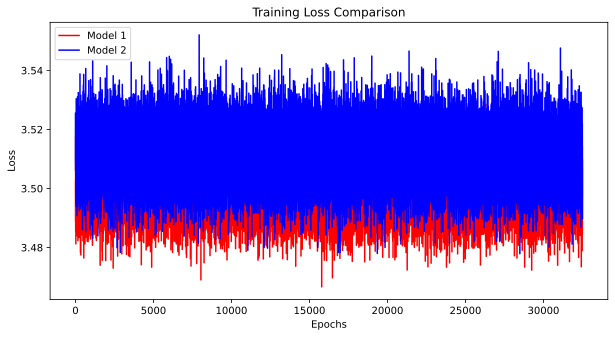

In [126]:
# 绘制损失曲线
plt.figure(figsize=(10, 5))  # 设置图的大小

# 绘制第一个损失曲线
plt.plot(range(len(losses_1)), losses_1, label='Model 1',color='red')

# 绘制第二个损失曲线
plt.plot(range(len(losses_2)), losses_2, label='Model 2',color='blue')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()  # 显示图例，以区分不同模型的曲线

save_path = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标/loss_comparison.png'
plt.savefig('MMS+DNN_loss_comparison.png')  # 保存图像

In [ ]:
# 绘制损失曲线，并保存

plt.plot(range(len(losses_1)), losses_1)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.plot(range(len(losses_2)), losses_2)
plt.xlabel('EPOCHS')
plt.ylabel('Loss')
plt.title('Training Loss')

In [127]:
# 打印，查看结果

accuracy_random = "{:.4f}".format(accuracy_score_1)
kappa_random = "{:.4f}".format(kappa_score_1)
opt_time_random = "{:.2f}".format(time_random)

accuracy_bayes = "{:.4f}".format(accuracy_score_2)
kappa_bayes = "{:.4f}".format(kappa_score_2)
opt_time_bayes = "{:.2f}".format(time_bayes)

print("\n","Accuracy_random:{}".format(accuracy_random)
    ,"\n","Kappa_random:{}".format(kappa_random)
    ,"\n","optimize_time_random:{}".format(opt_time_random))
print()
print("\n","Accuracy_bayes:{}".format(accuracy_bayes)
    ,"\n","Kappa_bayes:{}".format(kappa_bayes)
    ,"\n","optimize_time_bayes:{}".format(opt_time_bayes))


 Accuracy_random:0.0279 
 Kappa_random:-0.0009 
 optimize_time_random:25.38


 Accuracy_bayes:0.0248 
 Kappa_bayes:-0.0021 
 optimize_time_bayes:22.29


In [ ]:
# 保存 Accuracy，Kappa系数，优化时间
data = {
    'Random': [accuracy_random, kappa_random, opt_time_random],
    'Bayes': [accuracy_bayes, kappa_bayes, opt_time_bayes]
}

index = ['Accuracy', 'Kappa', 'Opt_time']
columns = ['Random', 'Bayes']

df = pd.DataFrame(data, index=index, columns=columns)
output_folder = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标'
csv_filename = 'SG+MMS_PCA_DNN(Mini-batch).txt'
df.to_csv(f'{output_folder}/{csv_filename}', sep='\t', index=True)

In [ ]:
# 保存混淆矩阵
output_folder = 'F:/Jupyter_Notebook_file/01_Spectrum Recognition/模型评价指标'

csv_filename_1 = 'cm_SG+MMS_PCA_DNN(Mini-batch)_Random.csv'
np.savetxt(f'{output_folder}/{csv_filename_1}', cm_1, delimiter=',', fmt='%d')

csv_filename_2 = 'cm_SG+MMS_PCA_DNN(Mini-batch)_Bayes.csv'
np.savetxt(f'{output_folder}/{csv_filename_2}', cm_2, delimiter=',', fmt='%d')